# **Home task - Timur Jerčaks**

Hi there! I'll use Python and the following libraries to analyze the provided datasets: pandas, statsmodels, and matplotlib. Additionally, before starting the analysis, I've separated the dataset into three CSV files: ``profile_holdings_monthly.csv``, ``profile_lifetime_activity.csv``, and ``profiles_onboarded_monthly.csv.``

Before getting started, I conducted brief research to acquaint myself with the provided product and created a short summary outlining what I am about to analyze:

**Wise Assets** - is a convenient combination of bank account and investment options. Users can choose whether to keep money simply in an account, earn low-risk interest income, or invest in the global stock market for potentially higher returns. (Internet)

## **Loading datasets and required libraries**

In [422]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [423]:
df_profile_holdings_monthly = pd.read_csv("profile_holdings_monthly.csv")
df_profile_lifetime_activity = pd.read_csv("profile_lifetime_activity.csv",)
df_profiles_onboarded_monthly = pd.read_csv("profiles_onboarded_monthly.csv")

In [424]:
# check the shape for each dataset
print("profiles_onboarded_monthly:",df_profiles_onboarded_monthly.shape)
print("profile_lifetime_activity:",df_profile_lifetime_activity.shape)
print("profile_holdings_monthly:",df_profile_holdings_monthly.shape)

profiles_onboarded_monthly: (10, 3)
profile_lifetime_activity: (10000, 11)
profile_holdings_monthly: (18010, 8)


I have noticed, that some of the columns have a date/time values, so i explicitly converted it to the timestamp datatype

In [425]:

date_columns_profile_lifetime_activity = [
    "PROFILE_CREATED", "FIRST_COMPLETED_ACTION", "FIRST_SEND", 
    "FIRST_BALANCE", "FIRST_TOP_UP", "FIRST_ACCOUNT_DETAILS",
    "FIRST_DIRECT_DEBIT", "FIRST_CARD", "FIRST_ASSETS"
] 

for col in date_columns_profile_lifetime_activity:
    df_profile_lifetime_activity[col] = pd.to_datetime(df_profile_lifetime_activity[col])

df_profile_holdings_monthly["MONTH_BALANCE"] = pd.to_datetime(df_profile_holdings_monthly["MONTH_BALANCE"], format="%Y-%m")
df_profiles_onboarded_monthly["MONTH"] = pd.to_datetime(df_profile_holdings_monthly["MONTH_BALANCE"], format="%Y-%m")

# df_profile_lifetime_activity.dtypes


----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

## 1) **What is the conversion rate to Assets?**
   


### **a) What are the steps in the conversion funnel(s) you have created?**


First, I will calculate the overall conversion rate (PROFILE_CREATED->FIRST_ASSETS funnel) by the formula:


$$ 
\text{Overall Conversion Rate} = \left( \frac{\text{Number of users who tried Assets}}{\text{Total number of users}} \right) \times 100
$$


In [426]:

total_number_of_users = df_profile_lifetime_activity["PROFILE_ID"].nunique() # total number of unique users id`s

dates_of_the_first_assets = df_profile_lifetime_activity["FIRST_ASSETS"] # the date, when the user first used the Assets

number_of_users_tried_assets = (total_number_of_users-dates_of_the_first_assets.isnull().sum())
conversion_rate = number_of_users_tried_assets/total_number_of_users

print(f"Conversion rate: {conversion_rate*100}%")

Conversion rate: 2.25%


As we can see, the overall conversion rate is quite low **(2.25%)**. Therefore, we need to analyze some user journey leading to Assets.
So, I will assume an ideal funnel that I believe users follow to achieve their first asset:

```PROFILE_CREATED → FIRST_COMPLETED_ACTION → FIRST_BALANCE → FIRST_TOP_UP → FIRST_ASSETS```

To calculate the percentages here, we need to multiply the step-by-step conversion rates cumulatively:

In [427]:
def calculate_conversion_rate_over_the_funnel(funnel:list, df:pd.DataFrame)->(dict):
    """For the given input calculates the funnel`s cummulative conversion rate"""
    funnel_conversion_by_action = {}
    df = df.copy()
    if(funnel[0] != "PROFILE_CREATED"):
        raise Exception("Each funnel should start with the 'PROFILE_CREATED' step")
    
    for index, n in enumerate(funnel):

        if(index == 0):
            # assume, that all of the funnels start with the PROFILE_CREATED step
            funnel_conversion_by_action["PROFILE_CREATED"] = 1.0 
            continue
        
        total_before_filtering = df.shape[0]

        filtered_df = df[pd.notnull(df[n])] # we filter df to leave only the not nulls users

        total_after_filtering = filtered_df.shape[0] 

        # conversion rate before/after filtering 
        conversion_rate = total_after_filtering/total_before_filtering 

        # conversion rate for the current step in the funnel with respect to the previous ones
        funnel_conversion_by_action[n] = funnel_conversion_by_action[funnel[index - 1]] *conversion_rate
        df = filtered_df

    print(fr"Conversion Rate for the Assets for the funnel [{'->'.join(funnel)}] is {funnel_conversion_by_action['FIRST_ASSETS']}")
    return funnel_conversion_by_action


In [428]:
def visualization_for_the_funnel(funnel: dict) -> None:
    """Just a function to create multiple visualizations for the funnel rates"""

    fig, axes = plt.subplots(1, 3, figsize=(len(funnel)*4, 7))
    fig.suptitle(f"Funnel Analysis for [{'->'.join(list(funnel.keys()))}] \n FIRST_ASSETS = {funnel['FIRST_ASSETS']}", fontsize=14)

    # Bar Chart
    axes[0].bar(list(funnel.keys()), list(funnel.values()), color="darkgreen")
    axes[0].set_title("Bar Chart")
    axes[0].set_xlabel("Columns")
    axes[0].set_ylabel("Conversion Rate")
    axes[0].tick_params(axis='x', rotation=45)

    # Line Chart
    axes[1].plot(list(funnel.keys()), list(funnel.values()), marker="o", linestyle="-", color="darkgreen")
    axes[1].set_title("Line Chart")
    axes[1].set_xlabel("Columns")
    axes[1].set_ylabel("Conversion Rate")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)

    # Waterfall Chart 
    diffs = np.diff([0] + list(funnel.values()))  
    axes[2].bar(list(funnel.keys()), diffs, color="darkgreen")
    axes[2].set_title("Waterfall Chart")
    axes[2].set_xlabel("Columns")
    axes[2].set_ylabel("Drop-off")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return 

Conversion Rate for the Assets for the funnel [PROFILE_CREATED->FIRST_COMPLETED_ACTION->FIRST_BALANCE->FIRST_TOP_UP->FIRST_ASSETS] is 0.0225


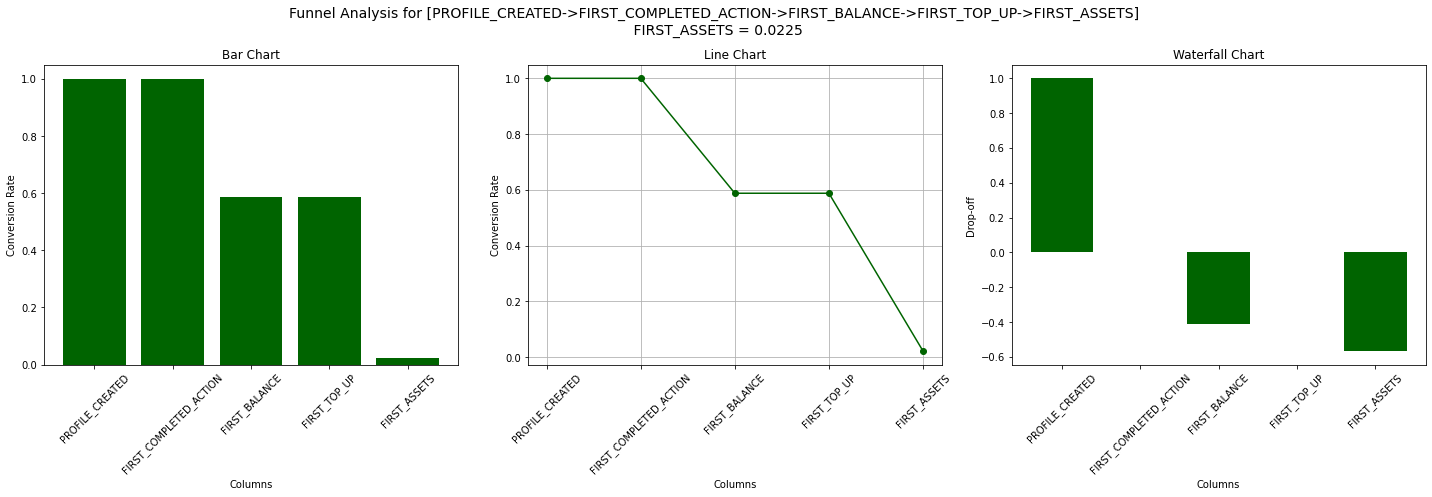

In [429]:
# we denote our funnel as the list of the columns
funnel = ["PROFILE_CREATED", "FIRST_COMPLETED_ACTION", "FIRST_BALANCE", "FIRST_TOP_UP", "FIRST_ASSETS"]

funnel_rates = calculate_conversion_rate_over_the_funnel(funnel, df_profile_lifetime_activity)
visualization_for_the_funnel(funnel_rates)


After implementing a universal tool to calculate the conversion rate for the Assets for every funnel we can simulate different variations to find the best one. I will try only couple of them:

Conversion Rate for the Assets for the funnel [PROFILE_CREATED->FIRST_ACCOUNT_DETAILS->FIRST_TOP_UP->FIRST_ASSETS] is 0.0174


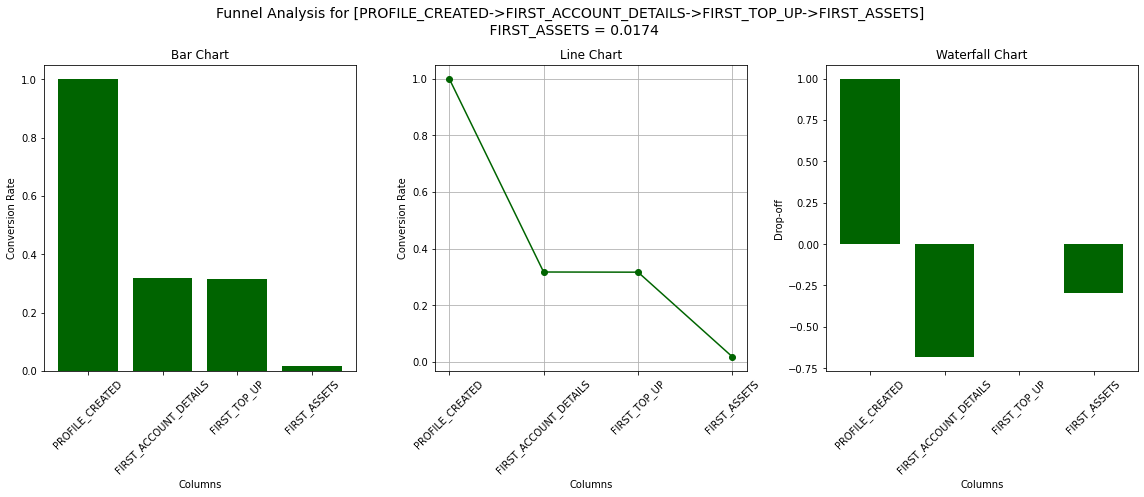

Conversion Rate for the Assets for the funnel [PROFILE_CREATED->FIRST_ACCOUNT_DETAILS->FIRST_ASSETS] is 0.0174


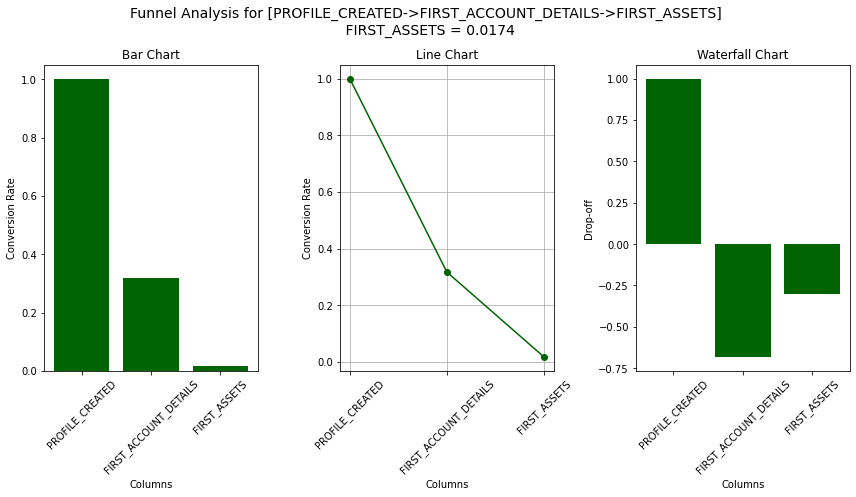

In [430]:
funnel_1 = ["PROFILE_CREATED", "FIRST_ACCOUNT_DETAILS", "FIRST_TOP_UP", "FIRST_ASSETS"]

funnel_rates = calculate_conversion_rate_over_the_funnel(funnel_1, df_profile_lifetime_activity)
visualization_for_the_funnel(funnel_rates)

funnel_2 = ["PROFILE_CREATED", "FIRST_ACCOUNT_DETAILS", "FIRST_ASSETS"]

funnel_rates = calculate_conversion_rate_over_the_funnel(funnel_2, df_profile_lifetime_activity)
visualization_for_the_funnel(funnel_rates)


**Conclusion on the a part:** By calculating the overall conversion rate, I determined the proportion of users who engaged with the Assets functionality. 

The analysis revealed that the overall conversion rate is relatively low, indicating that only a small percentage of total users reach the final step of the custome funnel. 

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

### **b) Within this simple dataset, try to identify what could be driving conversion rates to Assets.**


First, I have identified three potential factors that may influence a higher conversion rate:

1. The CLASS column, if there is any difference between two types of the customers on using the Assets
2. The time period (seasonality), if there are any trends in conversion rates over time
3. The ```profile_holdings_monthly.csv``` dataset, analyzing users` average monthly balance, segmented into different categories on this feature

Let's begin with the first one.

#### 1. **The CLASS column**

By grouping users into Personal and Business, we can analyze whether different user types influence the conversion rates to the Assets functionality. 

In [431]:
# PROFILE_CREATED(FILTERED)->FIRST_ASSETS funnel

# filter the datasets, to segregate classes
df_personal_class = df_profile_lifetime_activity[df_profile_lifetime_activity["CLASS"] == "Personal"]
df_business_class = df_profile_lifetime_activity[df_profile_lifetime_activity["CLASS"] == "Business"]

# calculate the totals 
total_personal = df_personal_class["PROFILE_ID"].nunique()
total_business = df_business_class["PROFILE_ID"].nunique()

# check the number of customers in each class for the potential imbalance
print(f"Total Personal: {total_personal}")
print(f"Total Business: {total_business}")

Total Personal: 8487
Total Business: 1513


At this point, I have observed a **noticeable class distribution imbalance**. Therefore, we need to approach this carefully and consider performing a statistical test to determine the significance of the difference between the two groups. However, for the statistical analysis, we can set aside these details for now and proceed with evaluating each property separately.

In [432]:
# calculate the number of users that have used Assets at least once
personal_number_assets = total_personal - df_personal_class["FIRST_ASSETS"].isnull().sum()
business_number_assets = total_business - df_business_class["FIRST_ASSETS"].isnull().sum()

# calculate the conversion rate
personal_conversion_rate = personal_number_assets / total_personal
business_conversion_rate = business_number_assets / total_business

print(f"Personal Conversion Rate: {round(personal_conversion_rate,4)}")
print(f"Business Conversion Rate: {round(business_conversion_rate, 4)}")

Personal Conversion Rate: 0.0191
Business Conversion Rate: 0.0416


We can clearly see that Business customers are more likely to use the Assets function, with a conversion rate of 4.16% compared to 1.91% for Personal customers. Therefore, the CLASS dimension should be considered a valuable factor influencing the use of the Assets functionality. Now, I will analyze this within the previously defined ideal funnel.

Conversion Rate for the Assets for the funnel [PROFILE_CREATED->FIRST_COMPLETED_ACTION->FIRST_BALANCE->FIRST_TOP_UP->FIRST_ASSETS] is 0.019088016967126194
Conversion Rate for the Assets for the funnel [PROFILE_CREATED->FIRST_COMPLETED_ACTION->FIRST_BALANCE->FIRST_TOP_UP->FIRST_ASSETS] is 0.041639127561136816


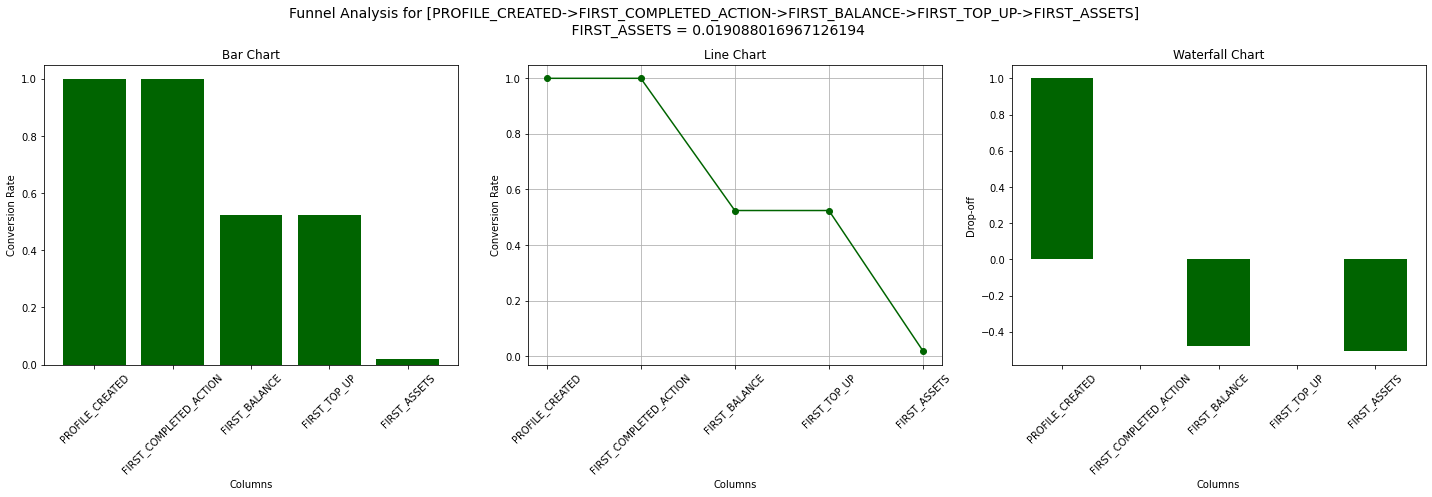

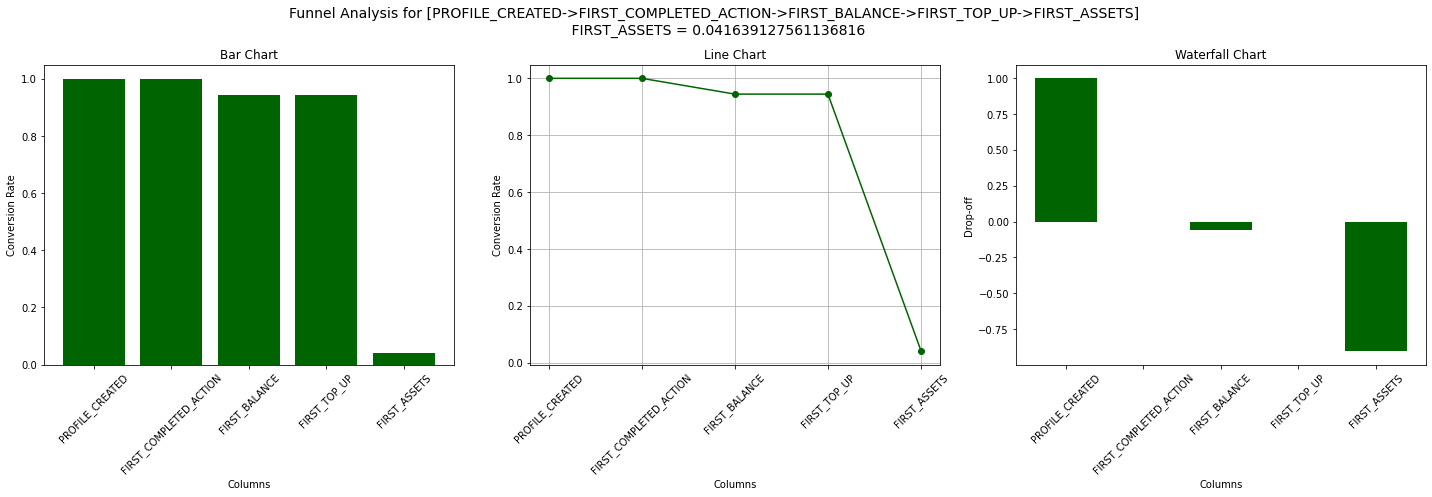

In [433]:
funnel = ["PROFILE_CREATED", "FIRST_COMPLETED_ACTION", "FIRST_BALANCE", "FIRST_TOP_UP", "FIRST_ASSETS"]
funnel_rates_personal = calculate_conversion_rate_over_the_funnel(funnel, df_personal_class)
funnel_rates_business = calculate_conversion_rate_over_the_funnel(funnel, df_business_class)

visualization_for_the_funnel(funnel_rates_personal)
visualization_for_the_funnel(funnel_rates_business)

Even though there is a significant class imbalance, we can see that Business clients generally experience a smaller conversion drop-off at each stage and are more likely to use the application for money transfers and holdings.

---------------------------------------------------------------------------------------------------------

#### 2. **The time period**

After examining the CLASS column, I will now analyze the monthly distribution to see **if there are any trends in conversion rates over time based on the users registration month.**. 

In [434]:
# create new column with the month, when the account was created
df_profile_lifetime_activity["profile_created_month"] = df_profile_lifetime_activity["PROFILE_CREATED"].dt.to_period("M")


In [435]:
# group by months
months_grouped = df_profile_lifetime_activity.groupby("profile_created_month").agg(total_new_profiles=("PROFILE_ID", "nunique"), used_assets=("FIRST_ASSETS", lambda x: x.notnull().sum()))
months_grouped = months_grouped.reset_index()

months_grouped["conversion_rate"] = (months_grouped["used_assets"] / months_grouped["total_new_profiles"]) 

# months_grouped = months_grouped.sort_values("conversion_rate", ascending=False)
print(months_grouped)


  profile_created_month  total_new_profiles  used_assets  conversion_rate
0               2023-01                1730           32         0.018497
1               2023-02                1552           29         0.018686
2               2023-03                1792           40         0.022321
3               2023-04                1615           42         0.026006
4               2023-05                1631           35         0.021459
5               2023-06                1680           47         0.027976


After grouping users by their registration month, I noticed that the number of onboarded users is approximately consistent across months, which makes this approach more reliable.

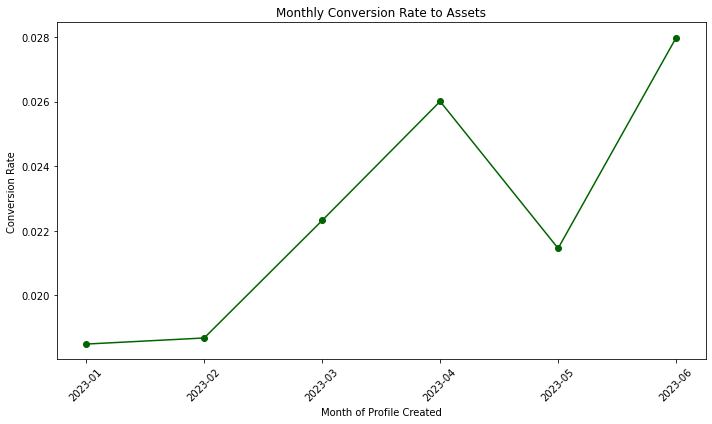

In [436]:
# plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(months_grouped["profile_created_month"].astype(str), months_grouped["conversion_rate"], marker="o", color="darkgreen")
plt.title("Monthly Conversion Rate to Assets")
plt.xlabel("Month of Profile Created")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We observe a trend: the conversion rate fluctuates over the months, but showes a growth.

---------------------------------------------------------------------------------------------------------

#### 3. **The ```profile_holdings_monthly.csv``` dataset**

And finally, using the historical data, I want to check **how users' average holdings impact their likelihood of using the Assets functionality**.

In [437]:
# merging two dataframes on the PROFILE_ID column and leaving only the date when the first asset was used or null
merged_df = df_profile_holdings_monthly.merge(df_profile_lifetime_activity[["PROFILE_ID", "FIRST_ASSETS"]], on="PROFILE_ID", how="left")

In [438]:
merged_df["used_assets"] = merged_df["FIRST_ASSETS"].notnull()

# we will calculate average holding for the each user at the beginning and the end
grouped_avg_holdings = merged_df.groupby("PROFILE_ID").agg( avg_begin_total=("BEGINNING_TOTAL_HOLDINGS_GBP", "mean"), avg_end_total=("END_TOTAL_HOLDINGS_GBP", "mean"), used_assets=("used_assets", "max"))
grouped_avg_holdings = grouped_avg_holdings.reset_index()

users_used_assets = grouped_avg_holdings[grouped_avg_holdings["used_assets"] == True]
users_did_not_use_assets = grouped_avg_holdings[grouped_avg_holdings["used_assets"] == False]

print("Used Assets average holdings:", users_used_assets["avg_begin_total"].mean())
print("Did not use Assets average holdings:", users_did_not_use_assets["avg_begin_total"].mean())


Used Assets average holdings: 8189.369037634409
Did not use Assets average holdings: 712.3928619902377


We can see that users with the highest average holdings tend to use the Assets functionality more frequently. Therefore, we can segment them into three categories (equally-sized bins) and analyze the conversion rates across these groups.

In [439]:
# we divide grouped df on segments using quantile-based bins (Low, Medium, High), based on avg_begin_total
grouped_avg_holdings["holdings_segment"] = pd.qcut(grouped_avg_holdings["avg_begin_total"], q=3, labels=['Low', 'Medium', 'High'])

conversion_rates_by_segment = grouped_avg_holdings.groupby("holdings_segment").agg(total_in_the_bin = ("holdings_segment", "count"), conversion_rate = ("used_assets", "mean"))
print("Conversion rates by holdings segments:\n", conversion_rates_by_segment)


Conversion rates by holdings segments:
                   total_in_the_bin  conversion_rate
holdings_segment                                   
Low                           1475         0.013559
Medium                        1451         0.036527
High                          1463         0.056049


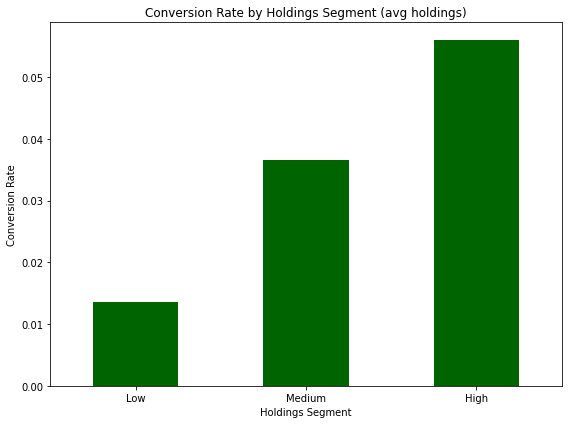

In [440]:
#  visualizing the results
plt.figure(figsize=(8,6))
conversion_rates_by_segment["conversion_rate"].plot(kind="bar", color="darkgreen")
plt.title("Conversion Rate by Holdings Segment (avg holdings)")
plt.xlabel("Holdings Segment")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Conclusion on the b part:** Through this fast analysis, I explored three factors that might influence conversion to Assets. 

- First, I segmented users by CLASS feature and found that Business users, despite being fewer in number, are more inclined to convert compared to Personal users. 

- Next, when examining conversion trends by month, I observed a decline over the time.

- Lastly, I looked at users’ account holdings and discovered a strong correlation: individuals with higher average holdings are significantly more likely to use Assets.

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

## 2) **Forecast the total number of asset customers 12 months into the future from the latest month of the dataset.**

To forecast the total number of customers 12 months into the future, I will use the **ARIMA model** from the statsmodels library. However, because we only have 12 data points (one year of monthly observations), the resulting forecast will be highly uncertain. 

In [441]:
# we group number of new asset users by months and prepare it
df_profile_lifetime_activity["new_asset_user_month"] = df_profile_lifetime_activity["FIRST_ASSETS"].dt.to_period("M")
month_grouped = df_profile_lifetime_activity.groupby("new_asset_user_month").agg(new_asset_users = ("PROFILE_ID", "nunique")).reset_index()
month_grouped = month_grouped.rename(columns={"new_asset_user_month": "month"})
month_grouped["month"] = month_grouped["month"].dt.to_timestamp()
month_grouped.set_index("month", inplace=True)

month_grouped

,new_asset_users
month,
2023-01-01,11
2023-02-01,9
2023-03-01,9
2023-04-01,12
2023-05-01,19
2023-06-01,37
2023-07-01,30
2023-08-01,25
2023-09-01,28


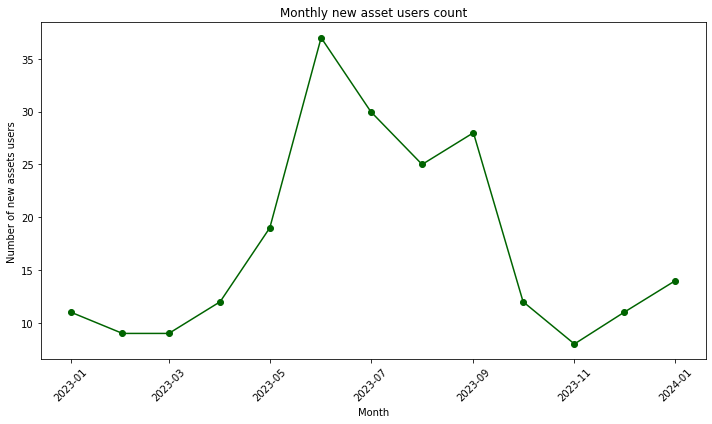

In [442]:
# plot the number of new asset users by month for the previous year
plt.figure(figsize=(10, 6))
plt.plot(month_grouped, marker="o", color="darkgreen")
plt.title("Monthly new asset users count")
plt.xlabel("Month")
plt.ylabel("Number of new assets users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [443]:
# we extract the time series column
ts = month_grouped["new_asset_users"]
ts

month
2023-01-01    11
2023-02-01     9
2023-03-01     9
2023-04-01    12
2023-05-01    19
2023-06-01    37
2023-07-01    30
2023-08-01    25
2023-09-01    28
2023-10-01    12
2023-11-01     8
2023-12-01    11
2024-01-01    14
Name: new_asset_users, dtype: int64

In [444]:
# using the ARIMA model, we fit it with our time series
model = sm.tsa.ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\l

In [445]:
# after the model fitting we use it to predict the next 12 months forecast
predicted = model_fit.get_forecast(steps=12)
predicted_conf_intervals = predicted.conf_int() 

predicted_serie = predicted.predicted_mean


In [446]:
df_combined = pd.concat([ts, predicted_serie], axis = 0)


HISTORY+FORECAST FOR THE NEW ASSET USERS (from 2023-01-01 to 2025-01-01)
2023-01-01    11.000000
2023-02-01     9.000000
2023-03-01     9.000000
2023-04-01    12.000000
2023-05-01    19.000000
2023-06-01    37.000000
2023-07-01    30.000000
2023-08-01    25.000000
2023-09-01    28.000000
2023-10-01    12.000000
2023-11-01     8.000000
2023-12-01    11.000000
2024-01-01    14.000000
2024-02-01    15.502197
2024-03-01    14.630861
2024-04-01    15.136272
2024-05-01    14.843113
2024-06-01    15.013157
2024-07-01    14.914525
2024-08-01    14.971735
2024-09-01    14.938551
2024-10-01    14.957799
2024-11-01    14.946634
2024-12-01    14.953110
2025-01-01    14.949354
dtype: float64


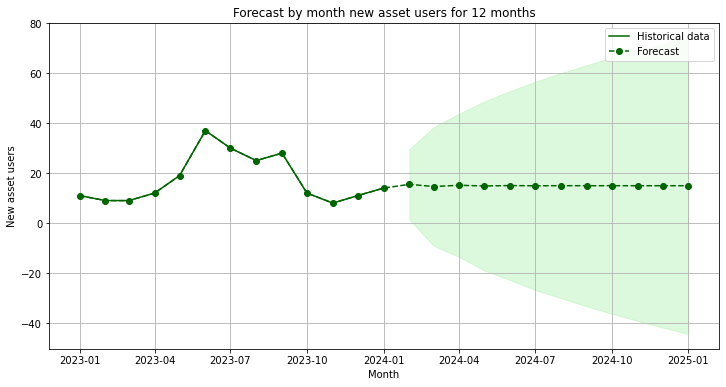

In [447]:
print("HISTORY+FORECAST FOR THE NEW ASSET USERS (from 2023-01-01 to 2025-01-01)")
print(df_combined)

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Historical data", color = "darkgreen")
plt.plot(df_combined, label="Forecast", color="darkgreen", marker = "o", linestyle = "--")
plt.fill_between(predicted_conf_intervals.index, predicted_conf_intervals.iloc[:, 0], predicted_conf_intervals.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title("Forecast by month new asset users for 12 months")
plt.xlabel("Month")
plt.ylabel("New asset users")
plt.legend()
plt.grid(True)
plt.show()

In [448]:
print(f"Total number of predicted new asset users: {round(predicted_serie.sum())}")

Total number of predicted new asset users: 180


**Conclusion on the 2nd question:** As I initially expected, it is very difficult to identify a clear trend with only one year of data. Even though there appears to be a spike in the summer months, we cannot confidently determine whether this was a one-time occurrence or a recurring seasonal pattern. As a result, the confidence interval is very wide, indicating a high level of uncertainty in the forecast. This highlights the limitations of making long-term predictions with such a small dataset, as the model lacks enough historical context to reliably capture trends or seasonality.

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

## 3) **Forecast the total holdings of customers by asset 12 months into the future from the latest month of the dataset.**

In this part, I will forecast the total holdings of customers for each asset type (cash, equity, and interest) using an ARIMA model. However, as in the previous question, we face the same problem: the amount of data is too small, so we cannot expect the forecasted results to be fully accurate.

In [449]:
# I have noticed many Nan values in the dataset, so we assume that it`s not the error in the data recording process and fill it with 0 values
df_profile_holdings_monthly.fillna(0, inplace=True)


Here I calculate the average balance for each asset type on a monthly basis. For each record, I compute the average equity, interest, and total holdings by taking the mean of the beginning and end values. Then, I calculatescash by subtracting the sum of equity and interest from the total holdings. 

In [450]:

# we take the average as the sum of the beginning and the end divided by 2
df_profile_holdings_monthly["avg_equity"] = (df_profile_holdings_monthly["BEGINNING_EQUITY_GBP"]+df_profile_holdings_monthly["END_EQUITY_GBP"])/2
df_profile_holdings_monthly["avg_interest"] = (df_profile_holdings_monthly["BEGINNING_INTEREST_GBP"]+df_profile_holdings_monthly["END_INTEREST_GBP"])/2
df_profile_holdings_monthly["avg_total"] =(df_profile_holdings_monthly["BEGINNING_TOTAL_HOLDINGS_GBP"]+df_profile_holdings_monthly["END_TOTAL_HOLDINGS_GBP"])/2 

# cash = total - (equity+interest)
df_profile_holdings_monthly["avg_cash"] = df_profile_holdings_monthly["avg_total"]-(df_profile_holdings_monthly["avg_equity"] + df_profile_holdings_monthly["avg_interest"])

# grouping the totals for each asset
monthly_assets = df_profile_holdings_monthly.groupby("MONTH_BALANCE")[["avg_equity", "avg_interest", "avg_cash"]].sum().reset_index()

monthly_assets = monthly_assets.rename(columns={"MONTH_BALANCE": "month"})

monthly_assets

,month,avg_equity,avg_interest,avg_cash
0,2023-01-01,1910.855,3537.785,111911.380
1,2023-02-01,3626.625,11014.230,538215.905
2,2023-03-01,2974.930,21053.525,1412544.620
3,2023-04-01,3607.670,110412.690,2432453.030
4,2023-05-01,6676.520,452523.560,3714843.810
5,2023-06-01,15194.970,981264.025,5037243.635


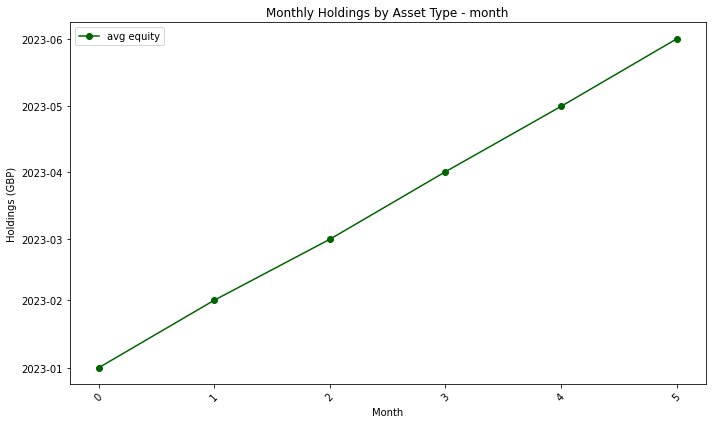

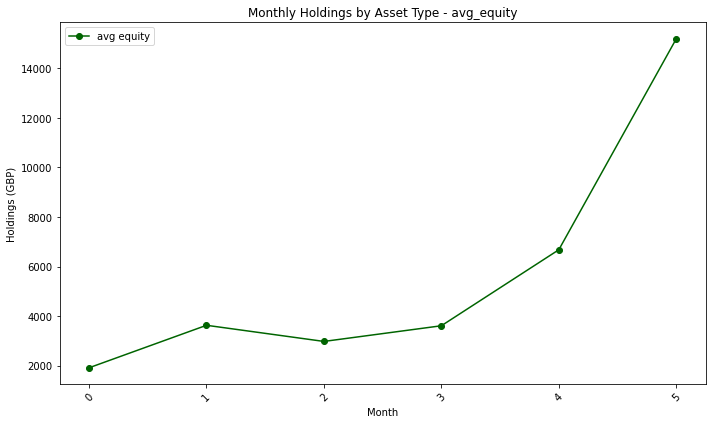

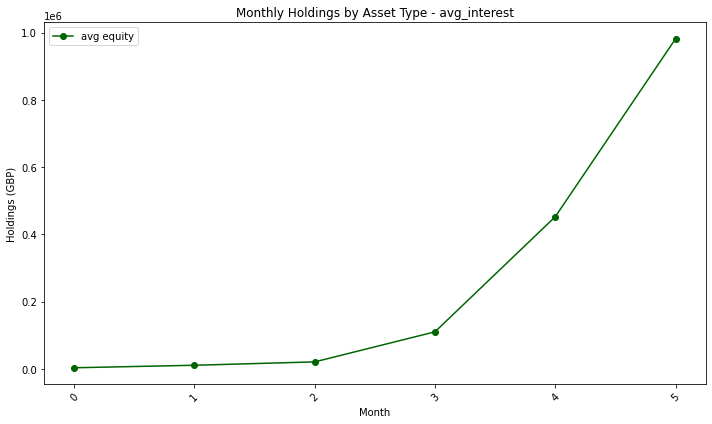

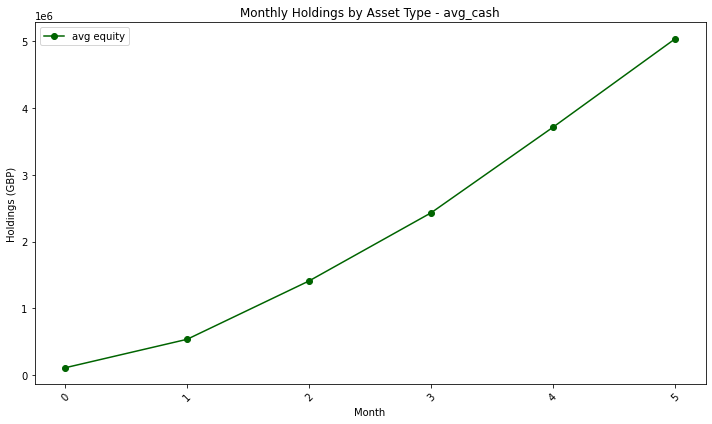

In [451]:
# plotting all the feature on separate plots
for n in list(monthly_assets.columns):
    plt.figure(figsize=(10, 6))

    plt.plot(monthly_assets.index, monthly_assets[n], marker="o", color="darkgreen", label="avg equity")

    plt.title(f"Monthly Holdings by Asset Type - {n}")
    plt.xlabel("Month")
    plt.ylabel("Holdings (GBP)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [452]:
monthly_assets.set_index("month", inplace=True)

In [453]:
# extract time series for the each feature
ts_equity = monthly_assets["avg_equity"]
ts_interest = monthly_assets["avg_interest"]
ts_cash = monthly_assets["avg_cash"]


After I have extracted the time series for each, I fit the ARIMA models for the each type

In [454]:
# using the ARIMA model, we fit it with our time series
model_equity = sm.tsa.ARIMA(ts_equity, order=(1, 1, 1))
model_interest = sm.tsa.ARIMA(ts_interest, order=(1, 1, 1))
model_cash = sm.tsa.ARIMA(ts_cash, order=(1, 1, 1))

model_fit_eq = model_equity.fit()
model_fit_interest = model_interest.fit()
model_fit_cash = model_cash.fit()

C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Timur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\l

In [455]:
# after the model fitting we use it to predict the next 12 months forecast
predicted_eq = model_fit_eq.get_forecast(steps=12)
predicted_conf_intervals_eq = predicted_eq.conf_int() 
predicted_serie_eq = predicted_eq.predicted_mean

predicted_interest = model_fit_interest.get_forecast(steps=12)
predicted_conf_intervals_interest = predicted_interest.conf_int() 
predicted_serie_interest = predicted_interest.predicted_mean

predicted_cash = model_fit_cash.get_forecast(steps=12)
predicted_conf_intervals_cash = predicted_cash.conf_int() 
predicted_serie_cash = predicted_cash.predicted_mean

After, we computed the predicted values, we need to combine them with the historical in the single dataframe

In [456]:
# combine historical data and the forecasted
ts_interest = ts_interest.asfreq("MS")

df_eq_combined = pd.concat([monthly_assets["avg_equity"], predicted_serie_eq], axis=0)
df_interest_combined = pd.concat([ts_interest, predicted_serie_interest], axis=0)
df_cash_combined = pd.concat([monthly_assets["avg_cash"], predicted_serie_cash], axis=0)



Again, we need to plot them separately for the close examination

HISTORY+FORECAST FOR THE EQUITY (from 2023-01-01 to 2024-06-01)
2023-01-01     1910.855000
2023-02-01     3626.625000
2023-03-01     2974.930000
2023-04-01     3607.670000
2023-05-01     6676.520000
2023-06-01    15194.970000
2023-07-01    22018.188715
2023-08-01    27483.539801
2023-09-01    31861.248290
2023-10-01    35367.762568
2023-11-01    38176.456296
2023-12-01    40426.200583
2024-01-01    42228.230225
2024-02-01    43671.643528
2024-03-01    44827.807619
2024-04-01    45753.887074
2024-05-01    46495.670325
2024-06-01    47089.833587
dtype: float64


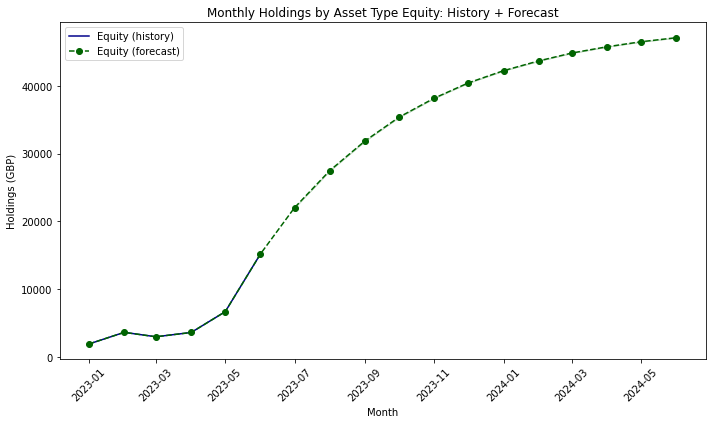

In [457]:
# equity forecast
print("HISTORY+FORECAST FOR THE EQUITY (from 2023-01-01 to 2024-06-01)")
print(df_eq_combined)

# visualization
plt.figure(figsize=(10, 6))

plt.plot(monthly_assets.index, monthly_assets["avg_equity"],  color="darkblue", label="Equity (history)")
plt.plot(df_eq_combined, linestyle="--", color="darkgreen", marker="o",label="Equity (forecast)")
plt.fill_between(predicted_conf_intervals_eq.index, predicted_conf_intervals_eq.iloc[:, 0], predicted_conf_intervals_eq.iloc[:, 1],color="darkgreen", alpha=0.2)

plt.title("Monthly Holdings by Asset Type Equity: History + Forecast")
plt.xlabel("Month")
plt.ylabel("Holdings (GBP)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

HISTORY+FORECAST FOR THE INTEREST (from 2023-01-01 to 2024-06-01)
2023-01-01    3.537785e+03
2023-02-01    1.101423e+04
2023-03-01    2.105352e+04
2023-04-01    1.104127e+05
2023-05-01    4.525236e+05
2023-06-01    9.812640e+05
2023-07-01    1.536744e+06
2023-08-01    2.088417e+06
2023-09-01    2.636310e+06
2023-10-01    3.180449e+06
2023-11-01    3.720858e+06
2023-12-01    4.257565e+06
2024-01-01    4.790593e+06
2024-02-01    5.319969e+06
2024-03-01    5.845717e+06
2024-04-01    6.367863e+06
2024-05-01    6.886430e+06
2024-06-01    7.401444e+06
Freq: MS, dtype: float64


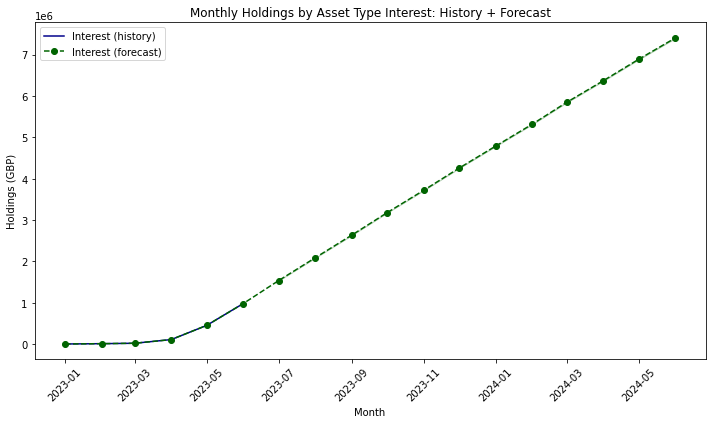

In [458]:
# equity forecast
print("HISTORY+FORECAST FOR THE INTEREST (from 2023-01-01 to 2024-06-01)")
print(df_interest_combined)

# visualization
plt.figure(figsize=(10, 6))

plt.plot(monthly_assets.index, monthly_assets["avg_interest"],  color="darkblue", label="Interest (history)")
plt.plot(df_interest_combined, linestyle="--", color="darkgreen", marker="o", label="Interest (forecast)")
plt.fill_between(predicted_conf_intervals_interest.index, predicted_conf_intervals_interest.iloc[:, 0], predicted_conf_intervals_interest.iloc[:, 1],color="darkgreen", alpha=0.2)

plt.title("Monthly Holdings by Asset Type Interest: History + Forecast")
plt.xlabel("Month")
plt.ylabel("Holdings (GBP)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

HISTORY+FORECAST FOR THE CASH (from 2023-01-01 to 2024-06-01)
2023-01-01    1.119114e+05
2023-02-01    5.382159e+05
2023-03-01    1.412545e+06
2023-04-01    2.432453e+06
2023-05-01    3.714844e+06
2023-06-01    5.037244e+06
2023-07-01    6.194776e+06
2023-08-01    7.337815e+06
2023-09-01    8.466542e+06
2023-10-01    9.581137e+06
2023-11-01    1.068178e+07
2023-12-01    1.176864e+07
2024-01-01    1.284189e+07
2024-02-01    1.390170e+07
2024-03-01    1.494824e+07
2024-04-01    1.598168e+07
2024-05-01    1.700218e+07
2024-06-01    1.800990e+07
dtype: float64


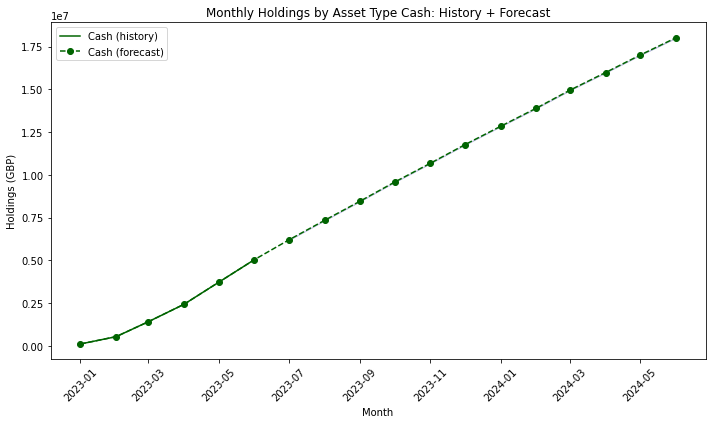

In [459]:
# cash forecast
print("HISTORY+FORECAST FOR THE CASH (from 2023-01-01 to 2024-06-01)")
print(df_cash_combined)

# visualization
plt.figure(figsize=(10, 6))

plt.plot(monthly_assets.index, monthly_assets["avg_cash"],  color="darkgreen", label="Cash (history)")
plt.plot(df_cash_combined, linestyle="--", color="darkgreen",marker="o", label="Cash (forecast)")
plt.fill_between(predicted_conf_intervals_cash.index, predicted_conf_intervals_cash.iloc[:, 0], predicted_conf_intervals_cash.iloc[:, 1],color="darkblue", alpha=0.2)

plt.title("Monthly Holdings by Asset Type Cash: History + Forecast")
plt.xlabel("Month")
plt.ylabel("Holdings (GBP)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusion on the 3rd question:** Based on the ARIMA models applied to each asset type (Equity, Interest, and Cash), the forecasts indicate a **consistent upward trend over the next 12 months**. 

However, there is an important consideration:

- **Small amount of the historical data**: The time series spans only a few months. This relatively short history can cause the model to extrapolate a trend that may not hold in the long term.

So, the ARIMA forecasts suggest that the total holdings in Equity, Interest, and Cash will continue to increase over the next year, but the limited dataset means these results should be interpreted with caution.

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

# *That`s all. Thank You!*